In [1]:
%pylab inline
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
import hmf
import astropy.io.ascii as ascii
import cosmology
cosmo=cosmology.Cosmo(h=1.,omega_m=0.315)
from scipy.interpolate import griddata
if False:
    figMsDir='/work/xiangchong.li/superonionGW/code/massMap_Private/doc/paper_ms_method_HSCY1/'
else:
    figMsDir='/home/xiangchong/Documents/Docs/massMap/paper_HSC2021/'

Populating the interactive namespace from numpy and matplotlib


In [23]:
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=0.05,Mmax=15.2,dlog10m=0.1,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>


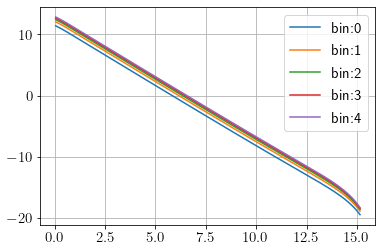

In [27]:
plt.close()
nsamp=25
zbound=np.linspace(0.01,0.85,nsamp+1)
zmin=zbound[:-1]
zmax=zbound[1:]
zave=(zmin+zmax)/2.

zlist=[]
mlist=[]
nlist=[]
for iz in range(0,5):
    z=zave[iz]
    mf.update(z=z)
    v=cosmo.V(zmin[iz],zmax[iz])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m
    plt.plot(np.log10(m),np.log10(mass_func),label='bin:%d' %iz)
plt.legend()
plt.grid()